# Комп'ютерне моделювання задач прикладної математики

## Основи класичної молекулярної динаміки. 

###  Лабораторна робота 2

***Студентка Пороскун Олена. Група ПМ.м-21***

*Task 2*

In [1]:
from matplotlib import pyplot as plt

In [2]:
import random
import numpy as np
import math
import time

In [3]:
count = 100 # кількість частинок

Розраховуємо випадкову величину.

In [4]:
def randV():
    #random.seed(s)
    max_num = 2147483647
    ksi = random.randint(0, max_num) / (max_num+1) # ksi = rand_r(&seedp)/(RAND_MAX+1.0);
    return ksi
#randV()

Розраховуємо початкові значення координат $(x_0,y_0)$ та швидкостей частинок $(vx_{0},vy_{0})$, що знаходяться у резервуарі розміром $(Lx,Ly)$.

In [5]:
def Inital_XY(N=10, Lx = 20, Ly = 20, vmax = 20):
    x0,  y0   = np.zeros(N), np.zeros(N)
    vx0, vy0  = np.zeros(N), np.zeros(N)
    for i in range(N):
        x0[i] = randV()*Lx;
        y0[i] = randV()*Ly;
        vx0[i] = vmax*(2*randV() - 1);
        vy0[i] = vmax*(2*randV() - 1);
    return x0, y0, vx0, vy0
#x0_, y0_, vx0_, vy0_ = Inital_XY()

In [6]:
x0, y0, vx0, vy0 = Inital_XY(N=count)

Перевіряємо межі початкових значень,

In [7]:
print(min(x0),min(y0))
print(max(vx0), max(vy0))

0.26554856449365616 0.19104905426502228
19.873318672180176 19.519715066999197


Перевіряємо розмірність масивів.

In [8]:
print(np.shape(x0),np.shape(y0), np.shape(vx0), np.shape(vy0))

(100,) (100,) (100,) (100,)


Виводимо перші 5 значень з кожного масиву.

In [9]:
list(zip(x0[:5], y0[:5]))

[(15.773125002160668, 8.313399041071534),
 (2.796621648594737, 10.571214957162738),
 (15.456303292885423, 14.710078490898013),
 (15.322227394208312, 1.2708038091659546),
 (17.543530883267522, 5.942685790359974)]

In [10]:
list(zip(vx0[:5], vy0[:5])) 

[(12.409982606768608, 11.300946287810802),
 (14.631292000412941, -14.609208796173334),
 (17.222262527793646, -8.845808207988739),
 (1.9811238907277584, -2.3282594233751297),
 (16.025061029940844, -15.055219419300556)]

Будуємо графік координат декількох перших частинок (за замовчуванням їх буде 10 або всі). 

In [11]:
def fun_plot1(x, y, n=10):
    
    if (n < 2):
        n = 1   
    if (n > len(x)):
        n = len(x)   
    
    # 1 спосіб
    for i in range(n):
        plt.scatter(x[i], y[i], s=30, label=f'{i+1}' " частинка")
        plt.text(x[i], y[i], "  "f'{i+1}')
        
    # 2 спосіб
    #plt.scatter(x[:n], y[:n], s=20, c='m') 

    plt.xlabel("x") 
    plt.ylabel("y")
    plt.title("Графік координат перших " f'{n}' " частинок" )
    if (n < 20):
        plt.legend(bbox_to_anchor=(1,1), loc="upper left")
    ax = [0, 20, 0, 20]
    ax2=[-1, 21, -1, 21]
    ax3=[-1, 32, -1, 21]
    plt.axis(ax2)
    
#fun_plot1(x0, y0) 

Розглянемо основнi iдеї методу молекулярної динамiки. Припустимо, що мiж N(N − 1)/2 парами частинок дiє двочастинковий потенцiал.  
$ \\ $   Як придатний приклад такого потенцiалу можна розглянути потенцiал Леннарда-Джонса 
$$ U(r_{12}) =  4\varepsilon \{ (\frac{\sigma}{r_{12}})^{12} - ( \frac{\sigma}{r_{12}})^6 \}$$
де $r_{12}$ — вiдстань мiж частинками 1 i 2,
$ \\ $ a $\varepsilon$ ("вiдстань" взаємодiї частинок 1 та 2) i σ (глибина потенцiальної ями або "енергiя") — сталi.

In [12]:
# (двочастинковий) потенцiал Леннарда-Джонса, що діє між N(N − 1)/2 парами частинками
def phi(r, sigma=1, eps=1):
    sr6 = (sigma/r)**6
    U_r = 4*eps*(sr6*sr6 - sr6)
    return U_r

Такий потенцiал добре описує притягання у випадку, коли частинки вiддаленi на значну вiдстань, i вiдштовхування, коли вони зближенi. У такому разi еволюцiя системи у часi вiдбувається вiдповiдно до детермiнiстичних законiв руху кожної частинки, причому сила взаємодiї $F_{ij}$ спрощується i подається так: 

$$ \overrightarrow{F}(|\overrightarrow{x_i}-\overrightarrow{x_j}|) = - \frac{\partial}{\partial \overrightarrow{x_i}}U(|\overrightarrow{x_i}-\overrightarrow{x_j}|) $$

In [13]:
# сила взаємодiї між частинкамии 
def F(r, sigma=1, eps=1):
    sr6 = (sigma/r)**6
    F_r = 24*eps*sigma/r*sr6*(2*sr6 - 1)
    return F_r

*Граничні умови (коли частинка виходить за межі резервуара)*

In [14]:
# жорсткі граничні умови
def Test11(X, Y, Vx, Vy, Lx=20, Ly=20):
    k=0
    while ((X < 0) | (X > Lx) | (Y < 0) | (Y > Ly)):
        if (X < 0):
            X = -X
            Vx = -Vx

        if (X > Lx):
            X = Lx-(X-Lx)
            Vx = -Vx

        if (Y < 0):
            Y = -Y
            Vy = -Vy 

        if (Y > Ly):
            Y = Ly-(Y-Ly)
            Vy = -Vy
        k+=1
    
    return X, Y, Vx, Vy, k

#X_, Y_, Vx_, Vy_, k_ = Test11(X=-4, Y=250, Vx=9, Vy=8, Lx=20, Ly=20) 
#print(X_, Y_, Vx_, Vy_) #4 10 -9 8

Використовуємо алгоритм Ейлера щоб розрахоувати координати $(x,y)$ частинок з часом та з цими даними розрахувати значення середнього часу $mpt(R)$ досягнення значення $R$(відстані, що пройшла частинка). 

### $$ Алгоритм \ Ейлера $$

$$ a_{xi} = \frac{F(x_i, y_i)}{m_i}=-\frac{1}{m_i}\frac{\partial}{\partial{x_i}} U(x_i, y_i) $$
$$ a_{yi} = \frac{F(x_i, y_i)}{m_i}=-\frac{1}{m_i}\frac{\partial}{\partial{y_i}} U(x_i, y_i) $$

$$ x_i(t+\Delta t) = x_i(t) + v_{xi}(t)\Delta t $$ 
$$ y_i(t+\Delta t) = y_i(t) + v_{yi}(t)\Delta t $$

$$ v_{xi}(t+\Delta t) = v_{xi}(t) + a_{xi}(t)\Delta t $$ 
$$ v_{yi}(t+\Delta t) = v_{yi}(t) + a_{yi}(t)\Delta t $$

$$ a = \frac{dv}{dt} = \frac{d^2x}{dt^2} $$
$$ \frac{dx}{dt} = v $$
$$ \frac{dv}{dt} = a $$

In [15]:
def funct2(x0, y0, vx0, vy0, R=1, mas=1, Lx=20, Ly=20, test_ = "Test11"):
    
    N = len(x0) # к-сть частинок
    
    t = 0       # початковий час
    dt = 0.0002 # крок по часу
    
    # тимчасовий 
    # масив координат та швидкостей
    x_n, y_n = np.zeros(N), np.zeros(N)
    vx_n, vy_n = np.zeros(N), np.zeros(N)
    
    times_R = np.zeros(N) # час для кожної частинки коли вона досягла R
    R_i = np.zeros(N)     # саме значення R_i(>=R), яке досягла кордината
    
    # mean pasage time (середній час досягнення значення R)
    mpt = 0
    
    for i in range(N):
        t = 0
        x, y = x0, y0
        vx, vy = vx0, vy0
        
        while (R_i[i] < R):
            
            t = round(t,5)

            X, Y = x[i], y[i]
            Vx, Vy = vx[i], vy[i]

            X1 = X + Vx*dt
            Y1 = Y + Vy*dt

            fx, fy = 0, 0 
            for j in range(N):
                if (j!=i):
                    rx = X1 - x[j]
                    ry = Y1 - y[j]
                    r = math.sqrt(rx*rx + ry*ry)      
                    if (r < math.sqrt(Lx*Lx + Ly*Ly)):
                        Fr = F(r)
                        Fr = Fr/mas
                        fx += (Fr * rx / r)
                        fy += (Fr * ry / r)

            Vx1 = Vx + fx*dt
            Vy1 = Vy + fy*dt

            if (test_ == "Test11"):
                X1, Y1, Vx1, Vy1, steps = Test11(X1, Y1, Vx1, Vy1)

            x_n[i], y_n[i] = X1, Y1
            vx_n[i], vy_n[i] = Vx1, Vy1    
            
            dx = X1 - x0[i]
            dy = Y1 - y0[i]
            R_i[i] += math.sqrt(dx*dx + dy*dy)
            
            if (R_i[i] >= R):
                times_R[i] = t

            x, y = x_n, y_n
            vx, vy = vx_n, vy_n
            
            t += dt        
    
    mpt = np.mean(times_R)
    mpt = round(mpt,5)
    
    #print("R","\t mpt")
    print(R, "\t", mpt)
    
    return times_R, R_i, mpt

In [16]:
#start_time = time.time()
R_ = [1, 2, 5, 10]
times = []   #
Ri    = []   #
mpt   = []   # mean pasage time (середній час досягнення значення R)
print("R","\t mpt")
for i in range(len(R_)):
    times_, Ri_, mpt_ = funct2(x0, y0, vx0, vy0, R = R_[i])
    times.append(times_)
    Ri.append(Ri_)
    mpt.append(mpt_)
#print("Ця частина коду виконувалася %s seconds." % round(time.time() - start_time, 2)) 

R 	 mpt
1 	 0.00463
2 	 0.00659
5 	 0.01034
10 	 0.01457


Перевіримо розмірність нових масивів.

In [17]:
print(np.shape(times))
print(np.shape(Ri))
print(np.shape(mpt))

(4, 100)
(4, 100)
(4,)


Функція, що априксимує дані, повертає: 
* coef - коефіцієнти рівняння, яке відповідає початковим даним, 
* polinom - рівняння з коефіцієнтами, 
* mpt_to_compare - значення функції для порівняння зі початковими.

In [18]:
def fun_aprox(X, mpt):
    k=1
    mpt_new = mpt*0
    eps = 1000
    bool_mpt = 0

    while ((eps >= 0.0001) & (k<10)):
        coef = np.polyfit(X, mpt,k)
        polinom = np.poly1d(coef)
        mpt_to_compare = polinom(X)
        
        mpt_old = np.round(mpt,5)
        mpt_to_compare = np.round(mpt_to_compare,5)

        eps = abs(mpt_old[0] - mpt_to_compare[0])
        bool_mpt = np.sum(mpt_old == mpt_to_compare)

        #print("\n k =",k)
        #print("coef:", coef)
        #print("y = aprox(x):\n",polinom)
        #print("Перевiрка:\n", " X =", X, "\n mpt = ", mpt_old,"\n mpt_to_compare =", mpt_to_compare)
        #print("bool_mpt =",bool_mpt)
        #print("eps =",eps)

        k += 1

    print("coef:", coef)
    print("y = aprox(x) :\n",polinom)
    print("Перевiрка:\n", " X =", X, "\n", mpt_old, "= mpt\n",mpt_to_compare,"= mpt_to_compare")
    
    return coef, polinom, mpt_to_compare

#c0, p0, mpt_to_compare0 = fun_aprox(R_, mpt)

Побудуємо тепер початкові дані та знайдену криву.

coef: [ 1.41111111e-05 -2.90388889e-04  2.73238889e-03  2.17388889e-03]
y = aprox(x) :
            3             2
1.411e-05 x - 0.0002904 x + 0.002732 x + 0.002174
Перевiрка:
  X = [1, 2, 5, 10] 
 [0.00463 0.00659 0.01034 0.01457] = mpt
 [0.00463 0.00659 0.01034 0.01457] = mpt_to_compare


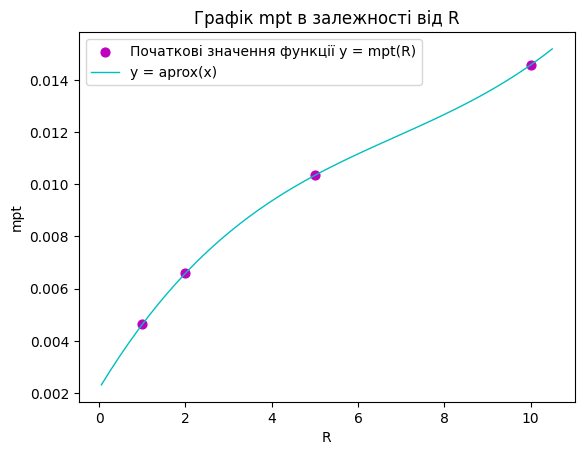

In [19]:
def fun_plot2(mpt, R = [1, 2, 5, 10]):
    
    plt.scatter(R, mpt, label="Початковi значення функції y = mpt(R)", s=40, c='m')
    
    # порівняння з апроксимованою кривою деякого степеня
    R_new = np.linspace(0.05, 10.5, 50)
    coef, polinom, mpt_to_compare = fun_aprox(R, mpt)
    mpt_new = polinom(R_new)
    plt.plot(R_new, mpt_new, label = "y = aprox(x)", linewidth = 1, c='c')
    
    plt.xlabel("R")
    plt.ylabel("mpt")
    plt.title("Графік mpt в залежності від R")
    plt.legend()

fun_plot2(mpt, R_)

### ---------------------------------------------------------------------------------------------